In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from pinns.prelude import *
from pinns.domain import Hypercube
from pinns.calc import laplace, divergence
from scipy.stats.qmc import Sobol
from pinns.model import mlp
from pinns.opt import train_nn
from pinns.integrate import integrate, midpoint, gauss2
from pinns.interpolate import shape_function
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [3]:
a = 1.
b = 1.
c = 1.
domain = Hypercube((-a / 2, -b / 2, -c / 2), (a / 2, b / 2, c / 2))
x_dom = array(Sobol(3, seed=0).random_base2(12))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(9))
x_bnd = domain.transform_bnd(x_bnd)

In [4]:
# TODO:
# find constants A, K1, Ms
# train init mag  # ok
# stray field solver  # ok
# compute Ha, Hex
# minimize energy

In [5]:
_x_bnd = array(Sobol(2, seed=1).random_base2(8))
_x_bnd = domain.transform_bnd(_x_bnd)
x1 = [_x_bnd[_x_bnd[:, i] == -0.5, :] for i in range(3)]
x2 = [_x_bnd[_x_bnd[:, i] == 0.5, :] for i in range(3)]
l = shape_function(x1, x2)

In [6]:
weights = array(Sobol(4, seed=12345).random_base2(8))
W_elm = (weights[:, :3] * 2 - 1) * 4
b_elm = (weights[:, 3] * 2 - 1) * 4


def unit_vec(x):
    return x / norm(x, axis=-1, keepdims=True)

def m_init_vortex(x):
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    rc = 0.14
    r = sqrt(x ** 2 + y ** 2)
    k = r**2 / rc**2

    mx = exp(-2*k)
    my = - z / r * sqrt(1 - exp(-4*k))
    mz = y / r * sqrt(1 - exp(-4*k))
    
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)


def m_init_flower(x):
    mx = 1 / a * x[..., 0] * x[..., 2]
    my = 1 / c * x[..., 1] * x[..., 2] + 1 / b ** 3 * x[..., 1] ** 3 * x[..., 2] ** 3
    mz = ones_like(my)
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)

# def m_init_flower(x):
#     return array([0, 0, 1.])


# def m_init_vortex(x):
#     m1 = zeros_like(x)
#     m1 = m1.at[..., 1].set(1.)
    
#     m2 = zeros_like(x)
#     m2 = m2.at[..., 1].set(-1.)
#     return where(x[..., 2] > 0., m1, m2)



In [7]:
def cat2sph(x):
    x = unit_vec(x)
    theta1 = jnp.arctan2(x[..., 1], x[..., 0])
    theta2 = jnp.arccos(x[..., 2])
    return jnp.stack([theta1, theta2], axis=-1)

def sph2cat(theta):
    theta1 = theta[..., 0]
    theta2 = theta[..., 1]
    x = cos(theta1) * sin(theta2)
    y = sin(theta1) * sin(theta2)
    z = cos(theta2)
    return jnp.stack([x, y, z], axis=-1)

In [8]:

from pinns.opt import train_nn

key, subkey = random.split(random.PRNGKey(42), 2)
mag_model, params = mlp(subkey, [4, 40, 40, 40,  2])
tx = optax.adam(0.001)
init_state = TrainState.create(
    apply_fn=mag_model.apply, 
    params=params,
    tx=tx
)

lam_dom = (8., 9.)

def draw_lam(key, n):
    return random.uniform(key, (n, )) * (lam_dom[1] - lam_dom[0]) + lam_dom[0]

def train_init_mag(theta_nn, state, m, key, epochs=1000):
    theta0 = cat2sph(vmap(m)(x_dom))
    
    @jit
    def make_batches(rng):
        k1, k2 = random.split(rng)
        batches = 24
        batch_size_dom = x_dom.shape[0] // batches

        perms_dom = jax.random.permutation(k1, x_dom.shape[0])
        perms_dom = perms_dom[:batches * batch_size_dom]  # skip incomplete batch
        perms_dom = perms_dom.reshape((batches, batch_size_dom))

        lam = draw_lam(k2, batches)
        
        return x_dom[perms_dom], theta0[perms_dom], lam
    
    @jit
    def loss(params, x, y, lex):
        lex = ones((x.shape[0])) * lex
        theta_pred = theta_nn.apply(params, jnp.append(x, lex[:, None], axis=-1))
        l = mean(norm(theta_pred - y, axis=-1) ** 2)
        return l, {'loss': l}

    return train_nn(loss, state, make_batches, key, epochs=epochs)
    # params = state.params
    # _theta_nn = lambda x: theta_nn.apply(params, x)
    # return _theta_nn, hist

key, train_key = random.split(key)
init_state_flower, hist = train_init_mag(mag_model, init_state, m_init_flower, train_key)
init_state_vortex, hist = train_init_mag(mag_model, init_state, m_init_vortex, train_key)

In [9]:
from pinns.elm import elm

_x_bnd = array(Sobol(2, seed=123).random_base2(14))
_x_bnd = domain.transform_bnd(_x_bnd)


def phi2_solution(x, x_bnd, phi1, l, m):
    eps = 1e-10
    def g(y):
        n = unit_vec(-grad(l)(y))
        return dot(m(y), n) - dot(grad(phi1)(y), n)
    
    dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
    _g = vmap(g)(x_bnd)
    def kernel(dist):
        idx = dist > eps
        newton_kernel = where(idx, 1 / dist, 0.)
        N = jnp.count_nonzero(idx)
        return 6 / (4 * pi * N) * dot(newton_kernel, _g)

    return vmap(kernel)(dist)


h_elm = lambda x: tanh(W_elm @ x + b_elm)
u_elm = lambda x: l(x) * h_elm(x)
Q_elm = vmap(lambda x: -laplace(u_elm)(x))(x_dom)
U_elm, S_elm, VT_elm = jax.scipy.linalg.svd(Q_elm, full_matrices=False, lapack_driver="gesvd")
H_bnd_elm = vmap(h_elm)(x_bnd)
U_bnd_elm, S_bnd_elm, VT_bnd_elm = jax.scipy.linalg.svd(H_bnd_elm, full_matrices=False, lapack_driver="gesvd")

def solve_stray_field(m):
    #u = lambda x: l(x) * h_elm(x)
    f = lambda x: -divergence(m)(x)
    #A = vmap(lambda x: -laplace(u)(x))(x_dom)
    b1 = vmap(f)(x_dom)
    #U, S, VT = jax.scipy.linalg.svd(A, full_matrices=False, lapack_driver="gesvd")
    params_phi1 = VT_elm.T @ ((1 / S_elm) * (U_elm.T @ b1))
    phi1 = lambda x: u_elm(x) @ params_phi1
    phi_bnd = phi2_solution(x_bnd, _x_bnd, phi1, l, m)
    #g2 = elm(h, x_bnd, phi_bnd, ridge=0.)
    params_phi_bnd = VT_bnd_elm.T @ ((1 / S_bnd_elm) * (U_bnd_elm.T @ phi_bnd))
    g2 = lambda x: h_elm(x) @ params_phi_bnd
    b2 = vmap(laplace(g2))(x_dom)
    params_phi2 = VT_elm.T @ ((1 / S_elm) * (U_elm.T @ b2))
    phi2 = lambda x: u_elm(x) @ params_phi2 + g2(x)
    phi_nn = lambda x: phi1(x) + phi2(x)
    return phi_nn


In [10]:
#phi = solve_stray_field(m_init_vortex)

In [11]:
# def ed(model, x):
#     Ms = 1.
#     H = lambda x: -grad(model)(x)
#     e = lambda x: dot(m_init_vortex(x), H(x)) 
#     return -Ms * (a * b * c) / 2 * jnp.sum(vmap(e)(x)) / len(x)

# abs(ed(phi, x_dom))

In [12]:
Ms = 1.
mu0 = 4 * pi * 1e-7
Km = 1 / 2 * Ms ** 2
K1 = 0.1 * Km


def exchange_energy(m, x, lam):
    A = 1 / (lam ** 2)
    
    def e_ex(x):
        
        dm = jacfwd(m)(x)
        #assert dm.shape == (3, 3)
        return jnp.sum(dm * dm)
        # lap_m = laplace(m)(x)
        # return dot(_m, lap_m)
    return -A * mean(vmap(e_ex)(x))

def ani_energy(m, x):
    def e_ani(x):
        c = array([0., 0., 1.])
        return 1 - (m(x) @ c) ** 2
        
    return 0.1 * mean(vmap(e_ani)(x))
    

def mag_energy(phi, m, x):
    def e_mag(x):
        H = lambda x: -grad(phi)(x)
        e = lambda x: dot(m(x), H(x)) 
        return e(x)
    
    return - mean(vmap(e_mag)(x))


def loss(params, x, lam):
    _m = lambda x: sph2cat(mag_model.apply(lax.stop_gradient(params), concatenate((x, lam[None]))))
    m = lambda x: sph2cat(mag_model.apply(params, concatenate((x, lam[None]))))
    phi = solve_stray_field(_m)
    
    e_ex = exchange_energy(m, x, lam)
    e_ani = ani_energy(m, x)
    e_mag = mag_energy(phi, m, x)
    e = e_ex + e_ani + e_mag
    _l = e_ex + e_ani + 2 * e_mag
    return _l, {'loss': _l, 'energy': e, 
                'e_ex': e_ex, 'e_ani': e_ani, 
                'e_mag': e_mag}


def train_mag(key, init_state, epochs, lr=1e-4, batch_size=32):        
    def make_batches(rng):
        batches = x_dom.shape[0] // batch_size
        k1, k2 = random.split(rng)
        batch_size_dom = x_dom.shape[0] // batches

        perms_dom = jax.random.permutation(k1, x_dom.shape[0])
        perms_dom = perms_dom[:batches * batch_size_dom]  # skip incomplete batch
        perms_dom = perms_dom.reshape((batches, batch_size_dom))
        
        lex = draw_lam(k2, batches)
        
        return x_dom[perms_dom], lex
    
    batches = x_dom.shape[0] // batch_size
    schedule = optax.linear_schedule(1e-5, 1e-7, epochs * batches // 2)
    tx = optax.radam(schedule)

    init_state = TrainState.create(
        apply_fn=mag_model.apply, 
        params=init_state.params,
        tx=tx
    )
    return train_nn(loss, init_state, make_batches, train_key, epochs=epochs)



In [13]:
key, train_key = random.split(key)
flower_state, hist_flower = train_mag(train_key, init_state_flower, epochs=500, lr=1e-5)

In [14]:
key, train_key = random.split(key)
vortex_state, hist_vortex = train_mag(train_key, init_state_vortex, epochs=500, lr=1e-5)

In [15]:
# key, train_key = random.split(key, 2)
# vortex_state, hist_vortex2 = train_mag(train_key, vortex_state, epochs=500, lr=1e-5)

In [17]:

def total_energy(state, lam):
    lam = array(lam)
    m = lambda x: sph2cat(mag_model.apply(state.params, concatenate((x, lam[None]))))
    phi = solve_stray_field(m)
    
    e_ex = exchange_energy(m, x_dom, lam)
    e_ani = ani_energy(m, x_dom)
    e_mag = mag_energy(phi, m, x_dom)
    
    e_tot = e_ex + e_ani + e_mag
    
    return {
        'e_tot': float(e_tot),
        'e_mag': float(e_mag),
        'e_ex': float(e_ex),
        'e_ani': float(e_ani),
    }

lam = 8.47
#l_ex = array(10)
print(total_energy(flower_state, lam))
print(total_energy(vortex_state, lam))

{'e_tot': -204.3218994140625, 'e_mag': 0.1809023916721344, 'e_ex': -204.5620574951172, 'e_ani': 0.05924791097640991}
{'e_tot': -95.22205352783203, 'e_mag': 0.26293644309043884, 'e_ex': -95.55889129638672, 'e_ani': 0.07390032708644867}


In [18]:
def total_energy(state, lam):
    lam = array(lam)
    m = lambda x: sph2cat(mag_model.apply(state.params, concatenate((x, lam[None]))))
    phi = solve_stray_field(m)
    
    e_ex = exchange_energy(m, x_dom, lam)
    e_ani = ani_energy(m, x_dom)
    e_mag = mag_energy(phi, m, x_dom)
    
    e_tot = e_ex + e_ani + e_mag
    
    return {
        'e_tot': e_tot,
        'e_mag': e_mag,
        'e_ex': e_ex,
        'e_ani': e_ani,
    }

@jit
def e(state, lam):
    return total_energy(state, lam)['e_tot']

lam = jnp.arange(8, 9.1, 0.1)
energies_flower = lax.map(lambda lam: e(flower_state, lam), lam)
energies_vortex = lax.map(lambda lam: e(vortex_state, lam), lam)

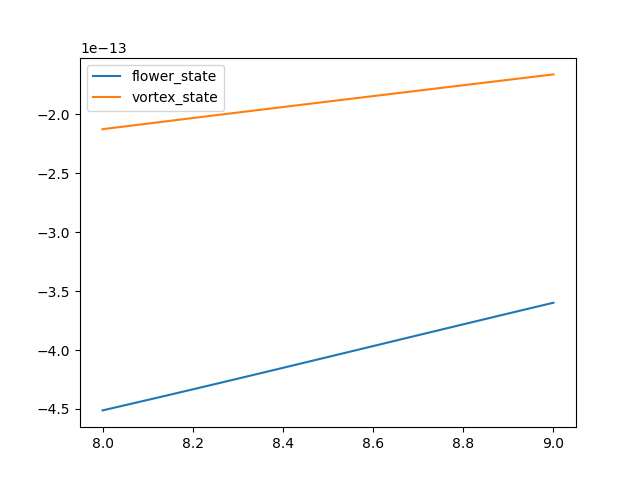

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lam, energies_flower * 2 * 1e-15, label="flower_state")
ax.plot(lam, energies_vortex * 2 * 1e-15, label="vortex_state")
ax.legend()


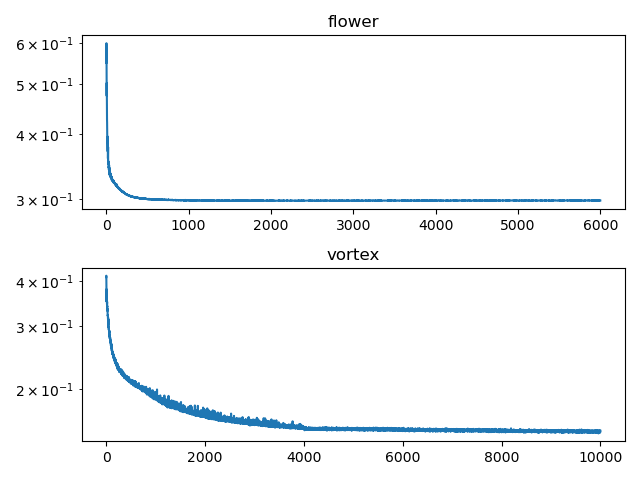

In [ ]:
fig = plt.figure()
ax1, ax2 = fig.subplots(2, 1)
ax1.plot(concatenate([hist_flower['loss'], hist_flower2['loss']]))
ax1.set_title("flower")
ax2.plot(concatenate([hist_vortex['loss'], hist_vortex2['loss']]))
ax2.set_title("vortex")
ax1.set_yscale('log')
ax2.set_yscale('log')
fig.tight_layout()


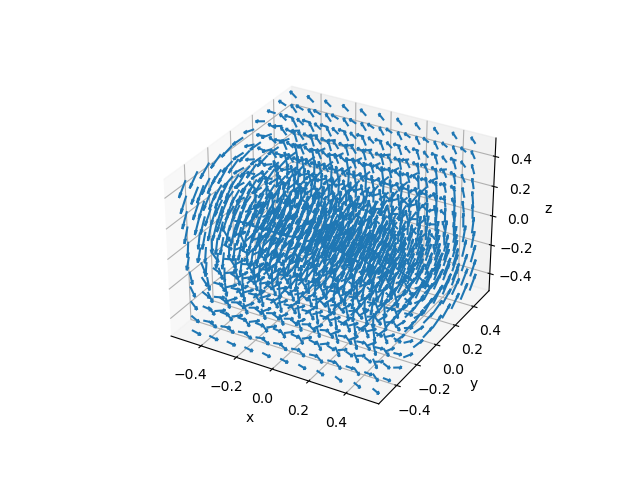

In [ ]:
i = 0
# z2 = lambda x: sph2cat(mag_model.apply(state.params, x))[i]


ax = plt.figure().add_subplot(projection='3d')

# Make the grid
x, y, z = jnp.meshgrid(jnp.arange(-0.5, 0.51, 0.1),
                      jnp.arange(-0.5, 0.51, 0.1),
                      jnp.arange(-0.5, 0.51, 0.1))

X = jnp.stack([x, y, z], axis=-1)
_X = X.reshape(-1, 3)

def _mag(state, lex):
    lex = array(lex)
    _mag = vmap(
        lambda x: sph2cat(mag_model.apply(state.params, concatenate((x, lex[None]))))
    )(_X).reshape(X.shape)
    return _mag

mag = _mag(vortex_state, 8.5)
# mag = _mag(init_state_flower, 8.)

ax.quiver(x, y, z, mag[..., 0], mag[..., 1], mag[..., 2], length=0.1, normalize=True)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.gcf().savefig("mag.png")
# plt.show()

In [ ]:
import numpy as np
from scipy.optimize import bisect

def _e_flower(lam):
    return np.array(e(flower_state, lam))

def _e_vortex(lam):
    return np.array(e(vortex_state, lam))

def energy_difference(lam):
    vortex = _e_vortex(array(lam))
    flower = _e_flower(array(lam))
    return vortex - flower

cross_section = array(bisect(energy_difference, 8., 9))
    

ValueError: f(a) and f(b) must have different signs

In [24]:
cross_section = array(8.47)

In [25]:
_x_dom2 = array(Sobol(3, seed=0).random_base2(16))
_x_dom2 = domain.transform(_x_dom2)

m_flower = lambda x, lam: sph2cat(mag_model.apply(flower_state.params, concatenate((x, lam[None]))))
m_vortex = lambda x, lam: sph2cat(mag_model.apply(vortex_state.params, concatenate((x, lam[None]))))

_m_flower = vmap(m_flower, (0, None))(_x_dom2, cross_section)
_m_vortex = vmap(m_vortex, (0, None))(_x_dom2, cross_section)

print("mean mag flower state:", mean(_m_flower, axis=0))
print("mean mag vortex state:", mean(_m_vortex, axis=0))

mean mag flower state: [-0.11715817  0.2608474   0.3421542 ]
mean mag vortex state: [-0.7764528  -0.11559655 -0.05155046]


In [ ]:
cross_section = array(8.464828)